# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
data_2019 = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [8]:
print("Datos úinicos 2019",data_2019['estacion'].unique())
print("")
print("Datos úinicos 2018",data_2018['estacion'].unique())
print("")
print("Datos úinicos 2017",data_2017['estacion'].unique())

Datos úinicos 2019 ['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

Datos úinicos 2018 ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Datos úinicos 2017 ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [9]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [10]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [11]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [12]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [13]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [14]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [15]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


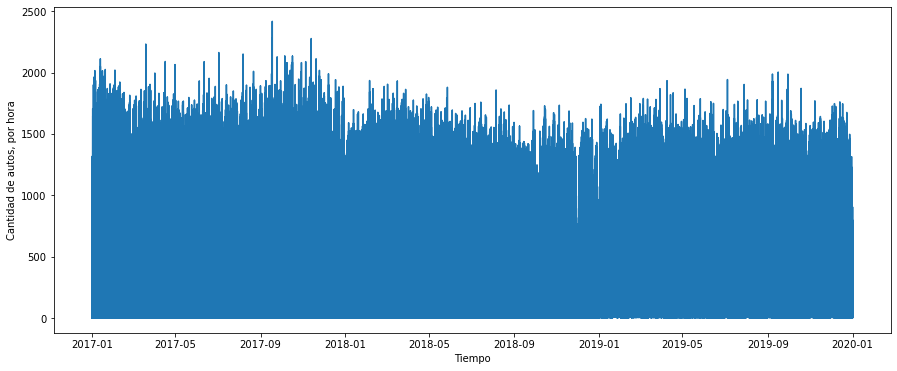

In [16]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [ ]:
dataset.to_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto', index= False)

In [27]:
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [5]:
dataset = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/dataset_final.csv')

In [6]:
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha)

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


# Análisis de Datos

In [ ]:
# Limpiar datos diarios
# Limpiar datos mensuales

Comenzaremos a analisar los datos con los que se trabajaran en este proyecto. 


Como primer paso, se visualizaran los datos en diferentes granularidades para comprender si deben recibir un tratamiento de preprocesamiento previo a un análisis de datos más profundos. 


Las granularidades que se analizaran serán de manera diaria y mensual, ya que serán con esas granularidades que se desarrollará el modelo predictivo y lograr predecir el último trimestre del 2019. 

### Datos a Diario

In [47]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha2').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha2,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


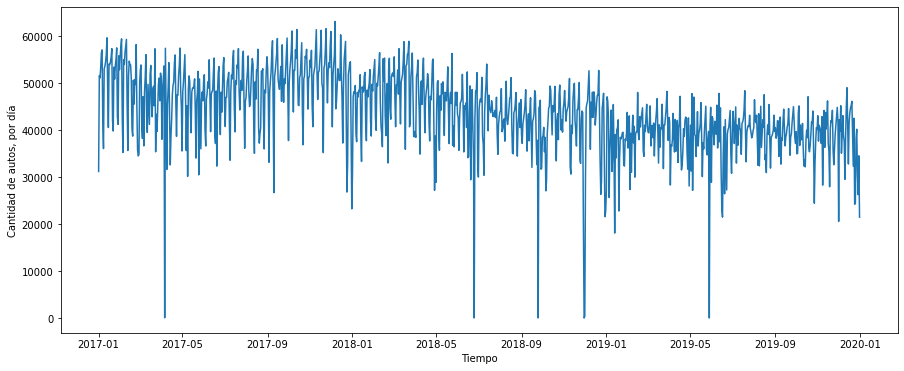

In [42]:
#Graficamos nuestros datos de manera diaria
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por día')
plt.show()

#### Graficando Outliers en Diario

<AxesSubplot:xlabel='cantidad_pasos'>

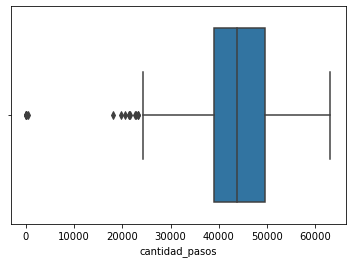

In [16]:
sns.boxplot(data = diario, x = "cantidad_pasos")

In [17]:
print("Los valores faltantes por cada columna son: ")
print(diario.isna().sum())

Los valores faltantes por cada columna son: 
cantidad_pasos    0
dtype: int64


#### Conclusiones

Una vez realizados las visualizaciones de los datos y de los outliers se puede concluir que la serie cuenta con valores outliers que deberán ser eliminados para el correcto funcionamiento de los modelos predictivos. 

### Datos a Meses

In [18]:
#Resampleamos nuestros datos para agrupar por mes.
mensual = dataset.resample('M', on = 'fecha2').sum()
print(mensual.shape)
mensual.head()

(36, 1)


,cantidad_pasos
fecha2,
2017-01-31,1565260
2017-02-28,1363113
2017-03-31,1451214
2017-04-30,1373985
2017-05-31,1407136


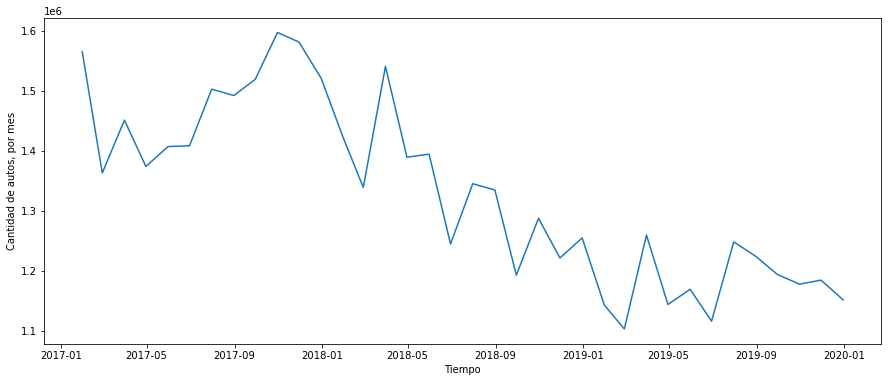

In [20]:
#Graficamos nuestros de manera mensual
plt.figure(figsize = (15,6))
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

#### Graficando Outliers en Mensual

<AxesSubplot:xlabel='cantidad_pasos'>

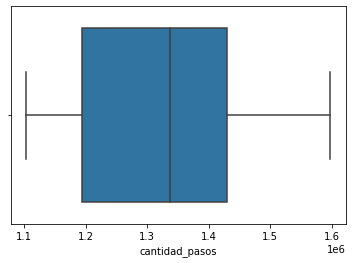

In [21]:
sns.boxplot(data = mensual, x = "cantidad_pasos")

In [50]:
print("Los valores faltantes por cada columna son: ")
print(mensual.isna().sum())

Los valores faltantes por cada columna son: 
cantidad_pasos    0
dtype: int64


#### Conclusiones

Una vez realizados las visualizaciones de los datos y de los outliers se puede concluir que la serie no cuenta con valores outliers. Pero se debe tomar en cuenta que se arrastrán los outliers encontrados en la granularidad diaria. Por lo que es preciso modificar los outlieres de manera diaria para una conclusión precisa sobre los datos mensuales. 

In [43]:
# Limpiar datos diarios
# Limpiar datos mensuales

# Preprocesamiento de datos

## Eliminación de valores outliers en granularidad diaria

A continuación, se procederá a utilizar la regla de las 3 sigmas para determinar cuales serán los valores outlieres a eliminar. 

In [30]:
diario.head()

,cantidad_pasos
fecha2,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [43]:
var_std = diario.cantidad_pasos.std()
promedio = diario.cantidad_pasos.mean()
print("La variación estándar es: ", var_std)
print("El promedio es: ", promedio)
print("El valor mínimo a considerar es: ", promedio - 3 * var_std)
print("El valor máximo a considerar es: ", promedio + 3 * var_std)
print("")

La variación estándar es:  8192.736926885047
El promedio es:  43712.859360730596
El valor mínimo a considerar es:  19134.648580075453
El valor máximo a considerar es:  68291.07014138575



In [44]:
valor_minimo= promedio - 3 * var_std

In [48]:
diario[diario.cantidad_pasos<=valor_minimo] = np.nan

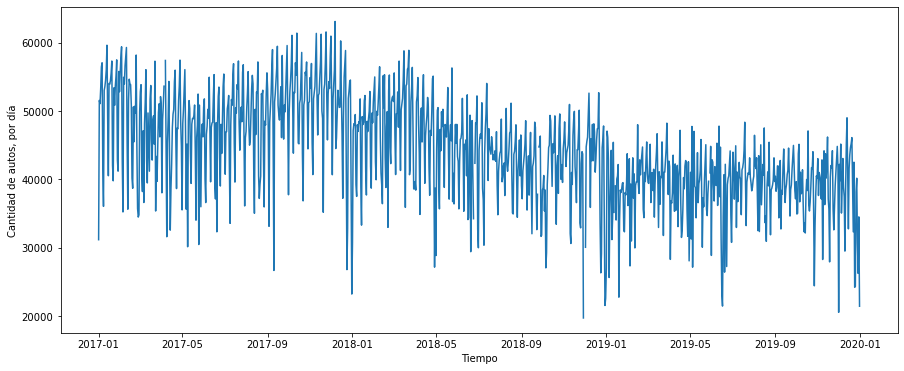

In [49]:
#Graficamos nuestros datos de manera diaria
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por día')
plt.show()

In [51]:
print("Los valores faltantes por cada columna son: ")
print(diario.isna().sum())

Los valores faltantes por cada columna son: 
cantidad_pasos    7
dtype: int64


Se puede apreciar en el gráfico que los outliers iniciales fueron removidos correctamente. Sin embargo, al realizarlo hemos eliminado 7 datos de los días (outlieres) que deberán ser rellenados para contar con una serie de tiempo completa. 

## Imputación de fechas faltantes

Se utilizará la técnica interpolate para imputar los datos faltantes por su sencillez de uso. 

In [52]:
diario = diario.interpolate() 

In [53]:
print("Los valores faltantes por cada columna son: ")
print(diario.isna().sum())

Los valores faltantes por cada columna son: 
cantidad_pasos    0
dtype: int64


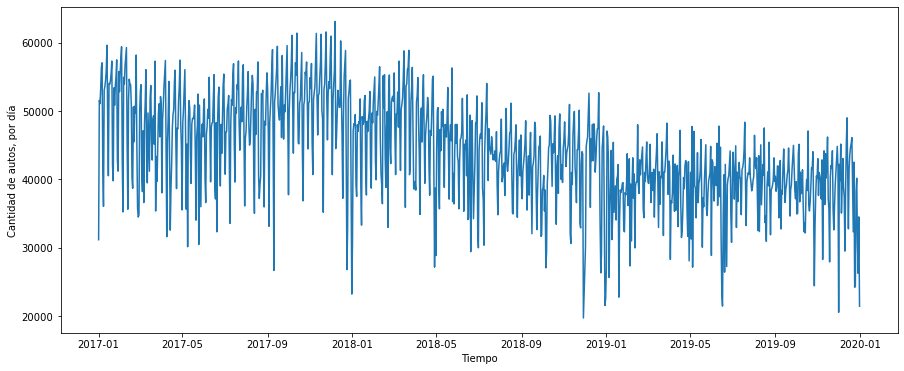

In [54]:
#Graficamos nuestros datos de manera diaria
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por día')
plt.show()

# Análisis de Datos

Text(0.5, 1.0, 'Tipos de automóviles')

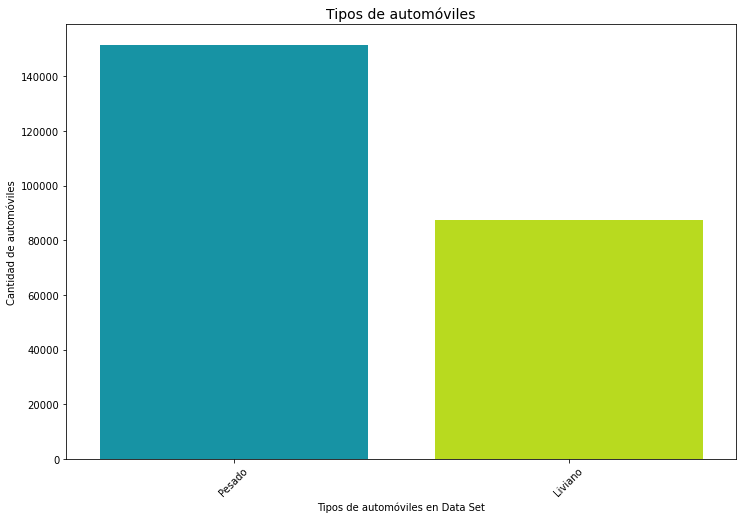

In [29]:
plt.figure(figsize = (12,8))
sns.countplot(data = dataset, x = "tipo_vehiculo", order = dataset['tipo_vehiculo'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Tipos de automóviles en Data Set')
plt.ylabel('Cantidad de automóviles')
plt.title('Tipos de automóviles', fontsize=14)

Text(0.5, 1.0, 'Sentido de los automóviles')

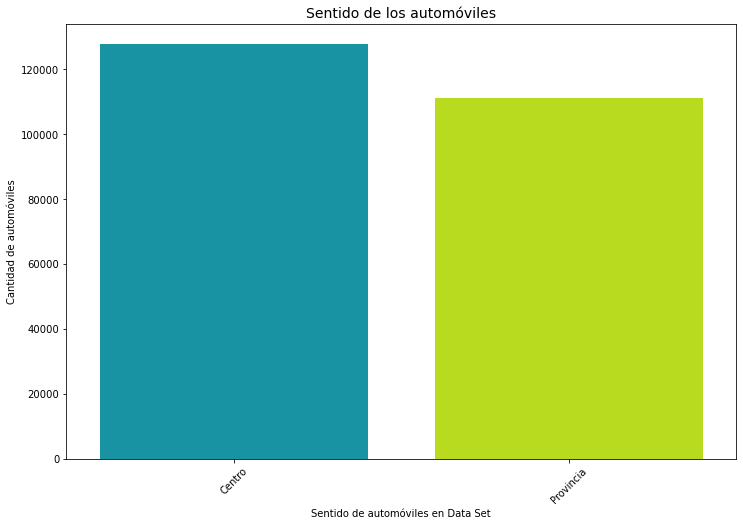

In [31]:
plt.figure(figsize = (12,8))
sns.countplot(data = dataset, x = "sentido", order = dataset['sentido'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Sentido de automóviles en Data Set')
plt.ylabel('Cantidad de automóviles')
plt.title('Sentido de los automóviles', fontsize=14)

Text(0.5, 1.0, 'Días de la semana y su tráfico')

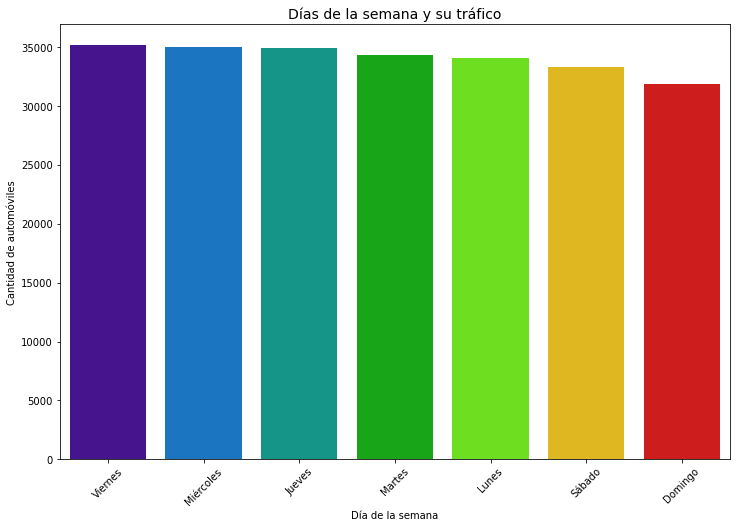

In [42]:
plt.figure(figsize = (12,8))
sns.countplot(data = dataset, x = "dia", order = dataset['dia'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de automóviles')
plt.title('Días de la semana y su tráfico', fontsize=14)

### Datos a horas

In [38]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
horas = dataset.resample('H', on = 'fecha').sum()
print(horas.shape)
horas.head()

(26280, 1)


,cantidad_pasos
fecha,
2017-01-01 00:00:00,1576
2017-01-01 01:00:00,1
2017-01-01 02:00:00,1374
2017-01-01 03:00:00,1734
2017-01-01 04:00:00,1247


In [ ]:
Aquñi


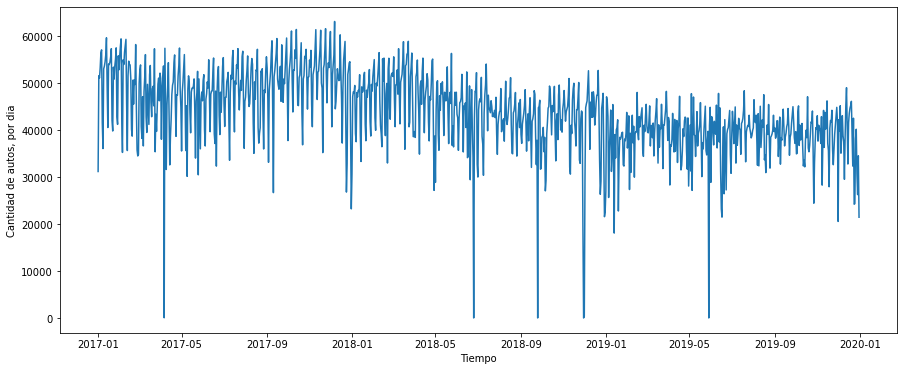

In [40]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()